In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from ipywidgets import *
import scipy.stats as sstats 
from scipy.stats import gaussian_kde as gkde

### Define plotting functions

In [2]:
def comparepush(x, obs_dens, post_dens):
    plt.plot(x, obs_dens.pdf(x.transpose()), 'y', label='obs')
    plt.plot(x, post_dens.evaluate(x), 'c', label='Q(post)')
    plt.xlabel('$Q(\lambda)$')
    plt.legend()
    plt.show()

def compare_input_dens(x, analytical_dens, estimated_dens, viewdim=0, lab_1='prior', lab_2='KDE prior', title=''):
    # specify viewdim (list) to view crosssections e.g. [0,1] gives you the diagonal view through the first two dimensions
    input_dim = estimated_dens.d
    num_samples = len(x)
    y = np.zeros( (input_dim, num_samples) )
    y[viewdim,:] = x 
    plt.plot(x, analytical_dens.pdf( y.transpose() ), 'y', label=lab_1)
    plt.plot(x, estimated_dens.evaluate(y), 'c', label=lab_2)
    if type(viewdim) == int:
        plt.xlabel('$\lambda_%d$'%viewdim)
    else:
        plt.xlabel('$\lambda_{%s}$'%str(viewdim))
    plt.title(title)
    plt.legend()
    plt.show()
    
def compare_output_dens(x, analytical_dens, estimated_dens, viewdim=0, lab_1='observed', lab_2='KDE push', title=''):
    # specify viewdim (list) to view crosssections e.g. [0,1] gives you the diagonal view through the first two dimensions
    input_dim = estimated_dens.d
    num_samples = len(x)
    y = np.zeros( (input_dim, num_samples) )
    y[viewdim,:] = x 
    plt.plot(x, analytical_dens.pdf( y.transpose() ), 'y', label=lab_1)
    plt.plot(x, estimated_dens.evaluate(y), 'c', label=lab_2)
    if type(viewdim) == int:
        plt.xlabel('$Q(\lambda_%d)$'%viewdim)
    else:
        plt.xlabel('$Q(\lambda_{%s})$'%str(viewdim))
    plt.title(title)
    plt.legend()
    plt.show()

def compare_est_input_dens(x, estimated_dens1, estimated_dens2, viewdim=0, lab_1='KDE prior', lab_2='KDE post', title=''):
    input_dim = estimated_dens1.d
    num_samples = len(x)
    y = np.zeros( (input_dim, num_samples) )
    y[viewdim,:] = x # specify dim (list) to view crosssections e.g. [0,1] gives you the diagonal view through the first two dimensions
    plt.plot(x, estimated_dens1.evaluate(y), 'y', label=lab_1)
    plt.plot(x, estimated_dens2.evaluate(y), 'c', label=lab_2)
    if type(viewdim)==int:
        plt.xlabel('$\lambda_%d$'%viewdim)
    else:
        plt.xlabel('$\lambda_{%s}$'%str(viewdim))
    plt.title(title)
    plt.legend()
    plt.show()
    
def pltaccept(lam, lam_accept, N, i=0, j=1): # plots first N of accepted, any 2D marginals specified
    plt.scatter(lam[i,:], lam[j,:], s=2)
    plt.scatter(lam_accept[i,0:N], lam_accept[j,0:N], s=4)
    plt.xlabel('$\lambda_%d$'%i)
    plt.ylabel('$\lambda_%d$'%j)
    plt.show()

## Sample from $\Lambda$

In [3]:
num_samples = int(1E4)
input_dim = 5
lam = np.random.normal( size = (input_dim, num_samples) ) # standard normal
x = np.linspace(-5, 5, 100) # for plotting purposes

---
## Define QoI Map
as one of the following: 

$q_1 = \lambda_1$  

$q_2 = \sum_{i=1}^n \lambda_i$  

$q_3 = \lbrace \lambda_0, \; \lambda_3 \rbrace$ 

$q_4 = \lbrace \lambda_0+\lambda_1, \; \lambda_2, \; \lambda_3-\lambda_4 \rbrace$  

In [4]:
def QoI_fun1(lam): # pull first element
    return np.array([ lam[0,:] ])

def QoI_fun2(lam): # sum all elements
    return np.array([ np.sum(lam,axis=0) ])

def QoI_fun3(lam): # pull two elements
    return np.array([ lam[0,:], lam[3,:] ])

def QoI_fun4(lam): # three elements
    return np.array([ lam[0,:]+lam[1,:], lam[2,:], lam[3,:]-lam[4,:] ])

In [5]:
QoI_choice = 4

if QoI_choice == 1:
    QoI_fun = QoI_fun1
elif QoI_choice == 2:
    QoI_fun = QoI_fun2
elif QoI_choice == 3:
    QoI_fun = QoI_fun3
elif QoI_choice == 4:
    QoI_fun = QoI_fun4
else:
    raise( ValueError('Specify Proper QoI choice!') )

---
## Compute QoI vector

Format: `(n_dims, n_samples)`

In [6]:
q = QoI_fun(lam)
print 'dimensions   --', "\t lambda:", lam.shape, '\t q:', q.shape

dimensions   -- 	 lambda: (5, 10000) 	 q: (3, 10000)


## Define observed density

In [7]:
var_const = 0.5
output_dim = q.shape[0]
# obs_dens = sstats.uniform(0, 2) # 1D only
# obs_dens = sstats.norm(0,0.25) # 1D only
# TODO: add support for multivariate uniforms. 

obs_dens = sstats.multivariate_normal(mean = np.zeros(output_dim), 
                                      cov = var_const*np.eye(output_dim) )

## Compute push-forward of the prior

In [8]:
pf_dens = gkde(q)

## Accept/reject sampling of posterior
(samples come from prior)

In [9]:
lam_accept = []
r = obs_dens.pdf( q.transpose() ) / pf_dens.evaluate(q)
M = np.max(r)
eta_r = r/M
for i in range(num_samples):
    xi = np.random.uniform(0,1)
    if eta_r[i] > xi:
        lam_accept.append( lam[:,i] )

lam_accept = np.array( lam_accept[1::] ).transpose()
num_accept = lam_accept.shape[1]
print 'Number accepted:', num_accept

Number accepted: 1740


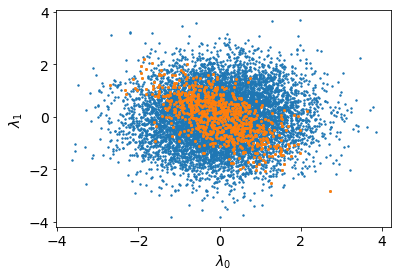

<function __main__.pltaccept>

In [10]:
interact(pltaccept, lam = fixed(lam), lam_accept = fixed(lam_accept), 
         N = (1, num_accept, 10), i = (0, input_dim-1, 1), j = (0, input_dim-1, 1))

---
## Visualize Posterior Density

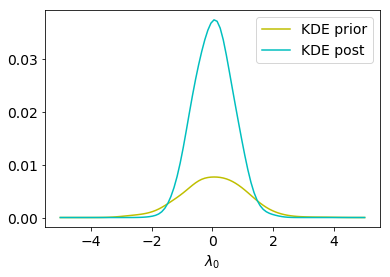

<function __main__.compare_est_input_dens>

In [11]:
prior_dens_kde = gkde(lam)
post_dens_kde = gkde(lam_accept) # Not very useful
# Can plot "slices" of densities to observe differences between posterior and prior, but not that useful
interact(compare_est_input_dens, x = fixed(x), 
         estimated_dens1 = fixed(prior_dens_kde), estimated_dens2 = fixed(post_dens_kde), 
         lab_1 = fixed('KDE prior'), lab_2 = fixed('KDE post'), title=fixed(''),
         viewdim=(0, input_dim-1, 1))


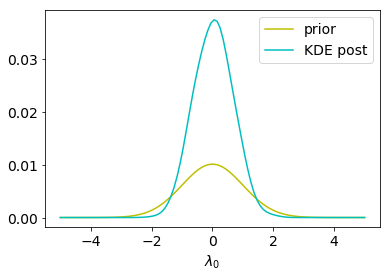

<function __main__.compare_input_dens>

In [12]:
prior_dens = sstats.multivariate_normal( mean = np.zeros(5), cov = np.eye(5) ) # Exact density
interact(compare_input_dens, x = fixed(x), 
         analytical_dens = fixed(prior_dens), estimated_dens = fixed(post_dens_kde), 
         lab_1 = fixed('prior'), lab_2 = fixed('KDE post'), title = fixed(''),
         viewdim = (0, input_dim-1, 1))

## Construct the push-forward of the posterior using accepted samples

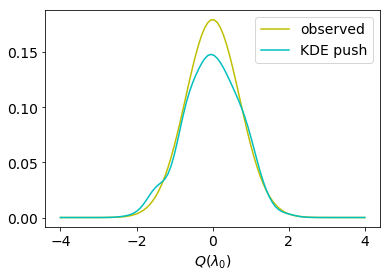

<function __main__.compare_output_dens>

In [13]:
x = np.linspace(-4, 4, 100)
# x = np.tile(np.linspace(-5,5,100),[output_dim,1])
push_post_dens_kde = gkde( QoI_fun(lam_accept) )
# Plot the push-forward of the posterior, should look like the observed density
interact(compare_output_dens, x = fixed(x), 
         analytical_dens = fixed(obs_dens), estimated_dens = fixed(push_post_dens_kde), 
         lab_1 = fixed('observed'), lab_2 = fixed('KDE push'), title = fixed(''),
         viewdim = (0, output_dim-1, 1))


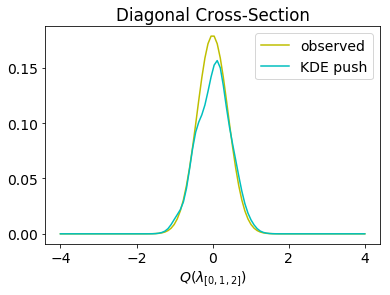

In [14]:
# diagonal crossection view
compare_output_dens(x, obs_dens, push_post_dens_kde, 
                    viewdim = range(output_dim), title = 'Diagonal Cross-Section')

---
## Extra visualizations

### Create KDE of samples on $\Lambda$ or use specified density on $\Lambda$

***The KDE is not necessary if the density on the input space is already specified***

Here, we just do this to show how the density estimator works compared to the exact density.

The KDE is not necessary except for the push-forward density. 

### Compare KDE of prior to the actual prior

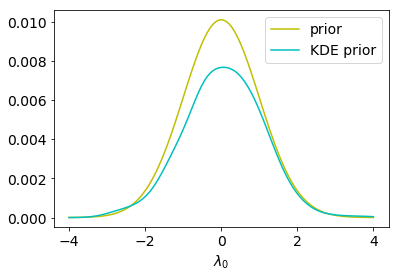

<function __main__.compare_input_dens>

In [15]:
interact(compare_input_dens, x = fixed(x), 
         analytical_dens = fixed(prior_dens), estimated_dens = fixed(prior_dens_kde),
         lab_1 = fixed('prior'), lab_2 = fixed('KDE prior'), title = fixed(''),
         viewdim = (0, input_dim-1, 1))

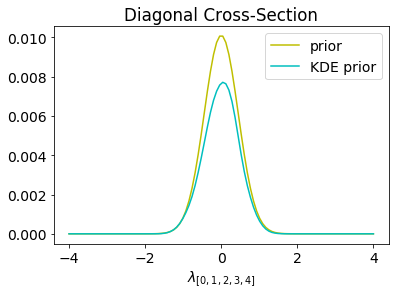

In [16]:
# diagonal crossection view
compare_input_dens(x, prior_dens, prior_dens_kde, 
                   viewdim = range(input_dim), title = 'Diagonal Cross-Section')